In [187]:
!pip install flappy-bird-gymnasium

In [188]:
import flappy_bird_gymnasium
import gymnasium as gym

In [189]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

In [190]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [191]:
env_name = "FlappyBird-v0"
max_episode_steps = -1
render_mode = "rgb_array"
num_envs = 4
env = gym.make_vec(
    env_name,
    max_episode_steps = max_episode_steps,
    render_mode = render_mode,
    num_envs = num_envs,
    vectorization_mode = "sync",
)

In [192]:
state, _ = env.reset()
state_dim = state.shape[-1]
action_dim = env.action_space[-1].n
print(state_dim, action_dim)

180 2


/opt/venv/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [193]:
class ActorCritic(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
        )
        self.actor = nn.Linear(256, action_dim)
        self.critic = nn.Linear(256, 1)
    
    def forward(self, state):
        x = self.model(state)
        action = self.actor(x)
        value = self.critic(x)
        if value.shape != torch.Size([1]):
            value = value.squeeze(1)
        return action, value

In [200]:
class PPOAgent():
    def __init__(self, lr = 2.5e-4, gamma = 0.99, lamb = 0.95,
                       clip_epsilon = 0.2, epochs = 4, mb_size = 4,
                       actor_coeff = 1.0, critic_coeff = 0.5, entropy_coeff = 0.01,
                       clip_grad_max_norm = 10.0):
        self.model = ActorCritic().to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr = lr)
        self.gamma = gamma
        self.lamb = lamb
        self.clip_epsilon = clip_epsilon
        self.epochs = epochs
        self.mb_size = mb_size
        self.actor_coeff = actor_coeff
        self.critic_coeff = critic_coeff
        self.entropy_coeff = entropy_coeff
        self.clip_grad_max_norm = clip_grad_max_norm

    def get_action_and_value(self, state, action = None):
        logits, value = self.model(state)
        
        dist = Categorical(logits=logits)
        
        if action is None:
            action = dist.sample()
            
        log_prob = dist.log_prob(action)
        
        return action, value, log_prob, dist.entropy()

    def calculate_advantages(self, rewards, values, last_value, masks):
        T = rewards.shape[0]
        advantages = []
        last_gae = 0
        for t in reversed(range(T)):
            next_value = last_value if t == T - 1 else values[t + 1]
            TD = rewards[t] + masks[t] * self.gamma * next_value - values[t]
            gae = last_gae = TD + masks[t] * self.gamma * self.lamb * last_gae
            advantages.insert(0, gae)
        advantages = torch.stack(advantages)
        return advantages

    def learn(self, states, last_state, actions, rewards, dones, old_values, old_log_probs):
        with torch.no_grad():
            _, last_value = self.model(last_state)
            masks = 1.0 - dones.float()
            raw_advantages = self.calculate_advantages(rewards, old_values, last_value, masks)
            advantages = (raw_advantages - raw_advantages.mean()) / (raw_advantages.std() + 1e-8)
            returns = raw_advantages + old_values
            
        def my_reshape(tensor):
            return tensor.reshape((tensor.shape[0] * tensor.shape[1], *tensor.shape[2:]))

        states = my_reshape(states)
        actions = my_reshape(actions)
        rewards = my_reshape(rewards)
        dones = my_reshape(dones)
        old_values = my_reshape(old_values)
        old_log_probs = my_reshape(old_log_probs)
        advantages = my_reshape(advantages)
        returns = my_reshape(returns)
        
        T = states.shape[0]
        
        for _ in range(self.epochs):
            perm = torch.randperm(T)
            for start in range(0, T, self.mb_size):
                mb_indices = perm[start:start + self.mb_size]
                
                mb_states = states[mb_indices]
                mb_actions = actions[mb_indices]
                mb_old_log_probs = old_log_probs[mb_indices]
                mb_advantages = advantages[mb_indices]
                mb_returns = returns[mb_indices]

                _, mb_values, mb_log_probs, mb_entropy = self.get_action_and_value(mb_states, action=mb_actions)
                loss_critic = nn.MSELoss(reduction = "mean")(mb_values, mb_returns)
                
                mb_ratios = torch.exp(mb_log_probs - mb_old_log_probs)
                mb_clipped_ratios = torch.clamp(mb_ratios, 1 - self.clip_epsilon, 1 + self.clip_epsilon)
                loss_actor = -torch.min(mb_ratios * mb_advantages, mb_clipped_ratios * mb_advantages).mean()
                
                loss = self.actor_coeff * loss_actor + self.critic_coeff * loss_critic - self.entropy_coeff * mb_entropy.mean()

                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_max_norm)
                self.optimizer.step()
# New PPO Agent
agent = PPOAgent()

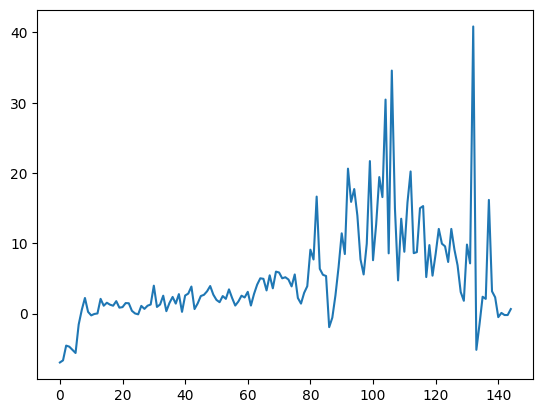

KeyboardInterrupt: 

In [201]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

performance_history = []
for steps in range(1000):
    states, actions, rewards, dones, values, log_probs = [], [], [], [], [], []
    running_done = torch.zeros(num_envs, dtype=torch.bool, device=device)
    state, _ = env.reset()
    while not running_done.all():
        state = torch.tensor(state, dtype=torch.float32, device=device)
        with torch.no_grad():
            action, value, log_prob, _ = agent.get_action_and_value(state)
        states.append(state)
        actions.append(action)
        values.append(value)
        log_probs.append(log_prob)
        state, reward, terminated, truncated, _ = env.step(action.unsqueeze(-1).cpu())
        terminated = torch.tensor(terminated, dtype=torch.bool, device=device)
        truncated = torch.tensor(truncated, dtype=torch.bool, device=device)
        done = torch.logical_or(terminated, truncated)
        dones.append(done)
        running_done = torch.logical_or(running_done, done)
        reward = torch.tensor(reward, dtype=torch.float32, device=device)
        reward = reward * (1.0 - running_done.float())
        rewards.append(reward)
    last_state = torch.tensor(state, dtype=torch.float32, device=device)
    states = torch.stack(states)
    actions = torch.stack(actions)
    rewards = torch.stack(rewards)
    dones = torch.stack(dones)
    values = torch.stack(values)
    log_probs = torch.stack(log_probs)
    agent.learn(states, last_state, actions, rewards, dones, values, log_probs)
    # Display statistics
    clear_output(wait=True)
    performance_history.append(rewards.T.sum(dim=1).mean().cpu())
    plt.plot(range(steps + 1), performance_history)
    plt.show()

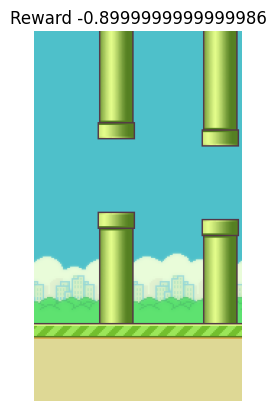

Episode finished. Total reward: -0.8999999999999986


In [204]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def show_env(env, agent = None):
    state, _ = env.reset()
    total_reward = 0

    done = False
    while not done:
        # Take environment step
        state = torch.tensor(state, dtype=torch.float32, device=device)
        action = env.action_space.sample()
        if agent:
            with torch.no_grad():
                action, _, _, _ = agent.get_action_and_value(state.unsqueeze(0))
        state, reward, terminated, truncated, _ = env.step(action.cpu())
        total_reward += reward

        done = terminated or truncated

        # Render from env
        frame = env.render()   # returns RGB array (H, W, 3)

        clear_output(wait=True)
        plt.imshow(frame)
        plt.axis("off")
        plt.title(f"Reward {total_reward}")
        plt.show()
    
    print("Episode finished. Total reward:", total_reward)

test_env = gym.make(
    env_name,
    max_episode_steps = max_episode_steps,
    render_mode = render_mode,
)
show_env(test_env, agent=agent)